In [ ]:
import numpy as np
from typing import Dict, List, Union


class SSRSimAPI:

    def load_model(self, *args, **kwargs):
        raise NotImplementedError

    def produce_results(self, names: List[str], times: List[float], sample_info: Union[int, List[Dict[str, float]]]) -> Dict[str, np.ndarray]:
        raise NotImplementedError

In [ ]:
from roadrunner import RoadRunner


class RoadRunnerSSR(SSRSimAPI):

    def __init__(self):
        self.rr = None

    def load_model(self, *args, **kwargs):
        self.rr = RoadRunner(*args)

    def produce_results(self, names: List[str], times: List[float], sample_info: Union[int, List[Dict[str, float]]]) -> Dict[str, np.ndarray]:
        if isinstance(sample_info, int):
            sample_size = sample_info
            do_sampling = False
        else:
            sample_size = len(sample_info)
            do_sampling = True

        results = {n: np.ndarray((sample_size, len(times)), dtype=float) for n in names}
        for i in range(sample_size):
            self.rr.resetAll()
            if do_sampling:
                for n, v in sample_info[i].items():
                    self.rr[n] = v
            res = self.rr.simulate(times=times)
            for n in names:
                results[n][i, :] = res[f'[{n}]']
        return results

In [3]:
import antimony
import libssr
from matplotlib import pyplot as plt
import numpy as np


def antimony_to_sbml(model_string: str) -> str:
    antimony.clearPreviousLoads()
    antimony.loadAntimonyString(model_string)
    module_name = antimony.getMainModuleName()
    return antimony.getSBMLString(module_name)


v_mean = 100.0
v_stdev = 20.0
model_names = ['S', 'I', 'R', 'V']
time_final = 10.0
num_steps = 100

model_str_antm = f"""
species S, I, R, V;

S -> I ; beta * S * V;
I -> R ; delta * I;
-> V  ; p * I - k * V;

S = 1E6;
I = 0.0;
R = 0.0;
V = normal({v_mean}, {v_stdev}, 0, {v_mean * 1E6});

beta = 2.0E-6;
k = 4.0;
delta = 1E0;
p = 25.0;
"""

model_str_sbml = antimony_to_sbml(model_str_antm)

In [4]:
sim_times = np.linspace(0., time_final, num_steps)
sample_size = 1000

rr_ssr = RoadRunnerSSR()
rr_ssr.load_model(model_str_sbml)
res_ssr = rr_ssr.produce_results(model_names, sim_times, sample_size)

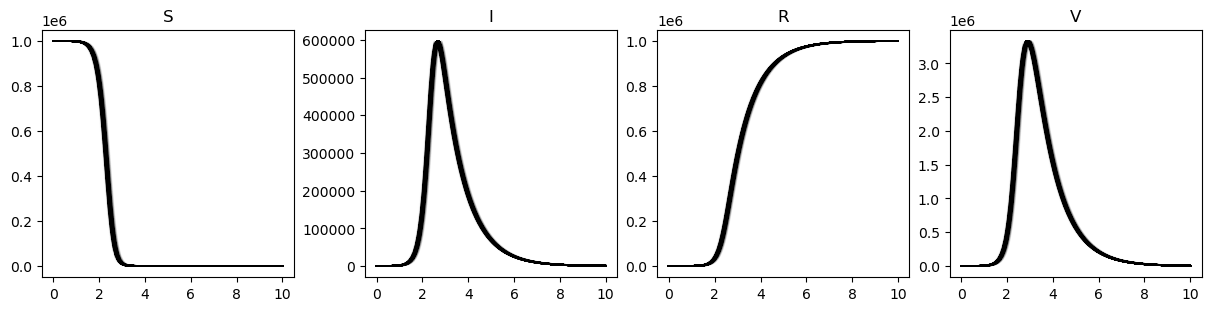

In [5]:
fig, axs = plt.subplots(1, len(model_names), layout='compressed', figsize=(12, 3))
for i, n in enumerate(model_names):
    for j in range(sample_size):
        axs[i].plot(sim_times, res_ssr[n][j, :], alpha=0.01, color='black')
    axs[i].set_title(n)

In [ ]:
num_evals = 100
num_pers = 5

eval_t_all = {n: [0.0] * num_steps for n in model_names}

for name in model_names:
    for i in range(num_steps):
        eval_t_all[name][i] = libssr.get_eval_info_times(num_evals, libssr.eval_final(res_ssr[name][:, i].T[:], num_pers))

ecf_j = {}
for name in model_names:
    ecf_n = np.ndarray((num_steps, num_evals, 2), dtype=float)
    for i in range(num_steps):
        ecf_n[i, :, :] = libssr.ecf(res_ssr[name][:, i].T, eval_t_all[name][i]).copy()
    ecf_j[name] = ecf_n.copy()

In [ ]:
err_sampling = libssr.sample_efect_error(res_ssr, err_thresh=1E-3)[0]
err_sampling

[0.1639765394944855,
 0.17591869398158244,
 0.15061469168137034,
 0.1810841226836403,
 0.16452356583140204,
 0.1952483990242677,
 0.16009233917205987,
 0.1487910475737554,
 0.1476813990823667,
 0.1732837684996397,
 0.16777519597247728,
 0.17462703910851768,
 0.1830430040121696,
 0.14418501827659258,
 0.16437227335637203,
 0.13688500967953787,
 0.19512142150009795,
 0.16205834285008414,
 0.1352512125348221,
 0.1848584299533703,
 0.17008622581705746,
 0.1327262592547055,
 0.16233531789928468,
 0.15883438947984335,
 0.15817016891644095,
 0.15719269787421064,
 0.1585039225125035,
 0.17227431492006104,
 0.18586702997198276,
 0.13665804671485812,
 0.144932159501926,
 0.12959098469725633,
 0.15129955069410653,
 0.15299376142672141,
 0.14180000020553649,
 0.16685092770160237,
 0.20247539623199112,
 0.16709079044439193,
 0.17450493877304366,
 0.21420133864818988,
 0.19605932593545602,
 0.13105271591689718,
 0.17962109413635402,
 0.19780886037630335,
 0.16888417873520406,
 0.15474826658547997,
 

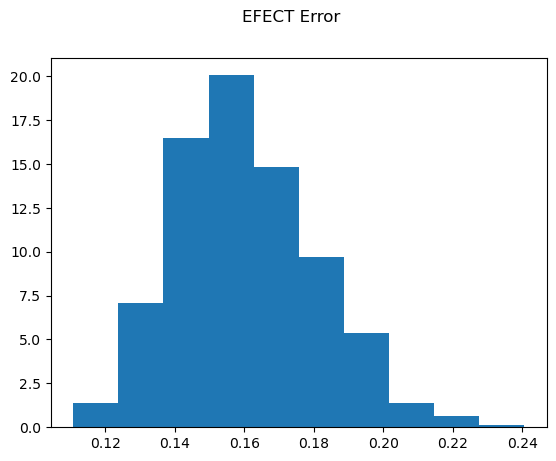

In [10]:
plt.hist(err_sampling, density=True)
_ = plt.suptitle('EFECT Error')